In [2]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils import data
import random
import open3d as o3d
import numpy as np
import torch.nn.functional as F
from datasets.shapenet_data_pc import cate_to_synsetid

class Uniform15KPC(Dataset):
    def __init__(
        self,
        root_dir,
        subdirs,
        tr_sample_size=10000,
        te_sample_size=10000,
        split="train",
        scale=1.0,
        normalize_per_shape=False,
        box_per_shape=False,
        random_subsample=False,
        normalize_std_per_axis=False,
        all_points_mean=None,
        all_points_std=None,
        input_dim=3,
        use_mask=False,
    ):
        """?

        Args:
            root_dir (_type_): _description_
            subdirs (_type_): _description_
            tr_sample_size (int, optional): _description_. Defaults to 10000.
            te_sample_size (int, optional): _description_. Defaults to 10000.
            split (str, optional): _description_. Defaults to "train".
            scale (float, optional): _description_. Defaults to 1.0.
            normalize_per_shape (bool, optional): _description_. Defaults to False.
            box_per_shape (bool, optional): _description_. Defaults to False.
            random_subsample (bool, optional): _description_. Defaults to False.
            normalize_std_per_axis (bool, optional): _description_. Defaults to False.
            all_points_mean (_type_, optional): _description_. Defaults to None.
            all_points_std (_type_, optional): _description_. Defaults to None.
            input_dim (int, optional): _description_. Defaults to 3.
            use_mask (bool, optional): _description_. Defaults to False.
        """
        self.root_dir = root_dir
        self.split = split
        self.in_tr_sample_size = tr_sample_size
        self.in_te_sample_size = te_sample_size
        self.subdirs = subdirs
        self.scale = scale
        self.random_subsample = random_subsample
        self.input_dim = input_dim
        self.use_mask = use_mask
        self.box_per_shape = box_per_shape

        self.all_cate_mids = []
        self.cate_idx_lst = []
        self.all_points = []
        for cate_idx, subd in enumerate(self.subdirs):
            # NOTE: [subd] here is synset id
            sub_path = os.path.join(root_dir, subd, self.split)
            if not os.path.isdir(sub_path):
                print("Directory missing : %s" % sub_path)
                continue

            all_mids = []
            for x in os.listdir(sub_path):
                if not x.endswith(".npy"):
                    continue
                all_mids.append(os.path.join(self.split, x[: -len(".npy")]))

            # NOTE: [mid] contains the split: i.e. "train/<mid>" or "val/<mid>" or "test/<mid>"
            for mid in all_mids:
                # obj_fname = os.path.join(sub_path, x)
                obj_fname = os.path.join(root_dir, subd, mid + ".npy")
                try:
                    point_cloud = np.load(obj_fname)  # (15k, 3)

                except Exception as e:
                    print(e)
                    continue

                self.all_points.append(point_cloud[np.newaxis, ...])
                self.cate_idx_lst.append(cate_idx)
                self.all_cate_mids.append((subd, mid))

        # Shuffle the index deterministically (based on the number of examples)
        self.shuffle_idx = list(range(len(self.all_points)))
        random.Random(38383).shuffle(self.shuffle_idx)
        self.cate_idx_lst = [self.cate_idx_lst[i] for i in self.shuffle_idx]
        self.all_points = [self.all_points[i] for i in self.shuffle_idx]
        self.all_cate_mids = [self.all_cate_mids[i] for i in self.shuffle_idx]

        # Normalization
        self.all_points = np.concatenate(self.all_points)  # (N, 15000, 3)
        self.all_points = self.all_points.transpose(0, 2, 1)
        self.normalize_per_shape = normalize_per_shape
        self.normalize_std_per_axis = normalize_std_per_axis
        if (
            all_points_mean is not None and all_points_std is not None
        ):  # using loaded dataset stats
            self.all_points_mean = all_points_mean
            self.all_points_std = all_points_std
        elif self.normalize_per_shape:  # per shape normalization
            B, N = self.all_points.shape[:2]
            self.all_points_mean = self.all_points.mean(axis=1).reshape(B, 1, input_dim)
            if normalize_std_per_axis:
                self.all_points_std = (
                    self.all_points.reshape(B, N, -1)
                    .std(axis=1)
                    .reshape(B, 1, input_dim)
                )
            else:
                self.all_points_std = (
                    self.all_points.reshape(B, -1).std(axis=1).reshape(B, 1, 1)
                )
        elif self.box_per_shape:
            B, N = self.all_points.shape[:2]
            self.all_points_mean = self.all_points.min(axis=1).reshape(B, 1, input_dim)

            self.all_points_std = self.all_points.max(axis=1).reshape(
                B, 1, input_dim
            ) - self.all_points.min(axis=1).reshape(B, 1, input_dim)

        else:  # normalize across the dataset
            self.all_points_mean = (
                self.all_points.reshape(-1, input_dim)
                .mean(axis=0)
                .reshape(1, 1, input_dim)
            )
            if normalize_std_per_axis:
                self.all_points_std = (
                    self.all_points.reshape(-1, input_dim)
                    .std(axis=0)
                    .reshape(1, 1, input_dim)
                )
            else:
                self.all_points_std = (
                    self.all_points.reshape(-1).std(axis=0).reshape(1, 1, 1)
                )

        self.all_points = (self.all_points - self.all_points_mean) / self.all_points_std
        self.test_points = self.all_points
        if self.box_per_shape:
            self.all_points = self.all_points - 0.5
            
        self.train_points = self.all_points

        self.tr_sample_size = min(10000, tr_sample_size)
        self.te_sample_size = min(5000, te_sample_size)
        print("Total number of data:%d" % len(self.train_points))
        print(
            "Min number of points: (train)%d (test)%d"
            % (self.tr_sample_size, self.te_sample_size)
        )
        assert self.scale == 1, "Scale (!= 1) is deprecated"

    def get_pc_stats(self, idx):
        if self.normalize_per_shape or self.box_per_shape:
            m = self.all_points_mean[idx].reshape(1, self.input_dim)
            s = self.all_points_std[idx].reshape(1, -1)
            return m, s

        return self.all_points_mean.reshape(1, -1), self.all_points_std.reshape(1, -1)

    def renormalize(self, mean, std):
        self.all_points = self.all_points * self.all_points_std + self.all_points_mean
        self.all_points_mean = mean
        self.all_points_std = std
        self.all_points = (self.all_points - self.all_points_mean) / self.all_points_std
        self.train_points = self.all_points[:, :10000]
        self.test_points = self.all_points[:, 10000:]

    def __len__(self):
        return len(self.train_points)

    def __getitem__(self, idx):
        tr_out = self.train_points[idx]
        if self.random_subsample:
            tr_idxs = np.random.choice(tr_out.shape[0], self.tr_sample_size)
        else:
            tr_idxs = np.arange(self.tr_sample_size)
        tr_out = torch.from_numpy(tr_out[tr_idxs, :]).float()

        te_out = self.test_points[idx]
        if self.random_subsample:
            te_idxs = np.random.choice(te_out.shape[0], self.te_sample_size)
        else:
            te_idxs = np.arange(self.te_sample_size)
        te_out = torch.from_numpy(te_out[te_idxs, :]).float()

        m, s = self.get_pc_stats(idx)
        cate_idx = self.cate_idx_lst[idx]
        sid, mid = self.all_cate_mids[idx]

        out = {
            "idx": idx,
            "train_points": tr_out,
            "test_points": te_out,
            "mean": m,
            "std": s,
            "cate_idx": cate_idx,
            "sid": sid,
            "mid": mid,
        }

        if self.use_mask:
            # masked = torch.from_numpy(self.mask_transform(self.all_points[idx]))
            # ss = min(masked.shape[0], self.in_tr_sample_size//2)
            # masked = masked[:ss]
            #
            # tr_mask = torch.ones_like(masked)
            # masked = torch.cat([masked, torch.zeros(self.in_tr_sample_size - ss, 3)],dim=0)#F.pad(masked, (self.in_tr_sample_size-masked.shape[0], 0), "constant", 0)
            #
            # tr_mask =  torch.cat([tr_mask, torch.zeros(self.in_tr_sample_size- ss, 3)],dim=0)#F.pad(tr_mask, (self.in_tr_sample_size-tr_mask.shape[0], 0), "constant", 0)
            # out['train_points_masked'] = masked
            # out['train_masks'] = tr_mask
            tr_mask = self.mask_transform(tr_out)
            out["train_masks"] = tr_mask

        return out

class ShapeNet15kPointClouds(Uniform15KPC):
    def __init__(
        self,
        root_dir="data/ShapeNetCore.v2.PC15k",
        categories=["airplane"],
        tr_sample_size=10000,
        te_sample_size=2048,
        split="train",
        scale=1.0,
        normalize_per_shape=False,
        normalize_std_per_axis=False,
        box_per_shape=False,
        random_subsample=False,
        all_points_mean=None,
        all_points_std=None,
        use_mask=False,
    ):
        self.root_dir = root_dir
        self.split = split
        assert self.split in ["train", "test", "val"]
        self.tr_sample_size = tr_sample_size
        self.te_sample_size = te_sample_size
        self.cates = categories
        if "all" in categories:
            self.synset_ids = list(cate_to_synsetid.values())
        else:
            self.synset_ids = [cate_to_synsetid[c] for c in self.cates]

        # assert 'v2' in root_dir, "Only supporting v2 right now."
        self.gravity_axis = 1
        self.display_axis_order = [0, 2, 1]

        super(ShapeNet15kPointClouds, self).__init__(
            root_dir,
            self.synset_ids,
            tr_sample_size=tr_sample_size,
            te_sample_size=te_sample_size,
            split=split,
            scale=scale,
            normalize_per_shape=normalize_per_shape,
            box_per_shape=box_per_shape,
            normalize_std_per_axis=normalize_std_per_axis,
            random_subsample=random_subsample,
            all_points_mean=all_points_mean,
            all_points_std=all_points_std,
            input_dim=3,
            use_mask=use_mask,
        )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [34]:
test1 = np.load("./custom-dataset/02691156/train/sample-1.npy")
test2 = np.load("./custom-dataset/02691156/train/sample-2.npy")

array = np.array([test1, test2])
print(array.shape)

array.transpose(0, 2, 1).shape

(2, 3, 2048)


(2, 2048, 3)

In [4]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:20
Min number of points: (train)2048 (test)2048


In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size=1, sampler=None, shuffle=True is None, num_workers=1, drop_last=True)

(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c85255c10>
Traceback (most recent call last):
  File "/home/kristiyan/.cache/pypoetry/virtualenvs/coarse-to-fine-shapes-aa7c6m2--py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/kristiyan/.cache/pypoetry/virtualenvs/coarse-to-fine-shapes-aa7c6m2--py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.

(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)


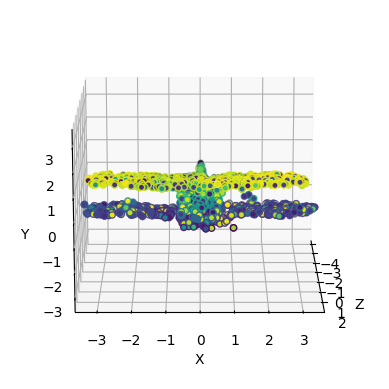

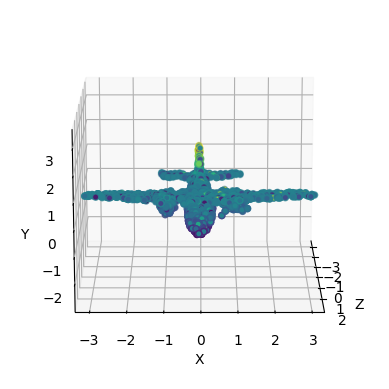

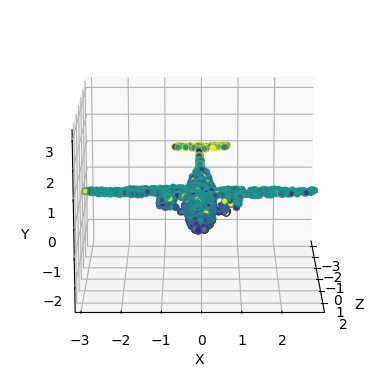

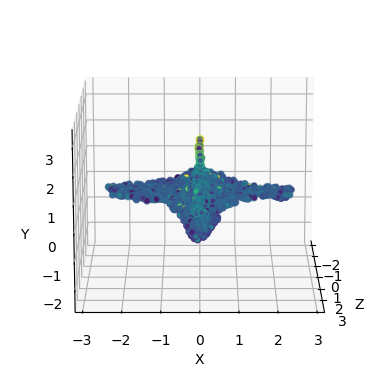

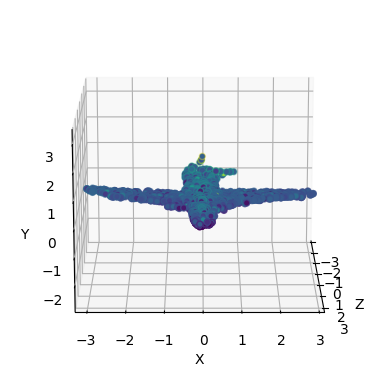

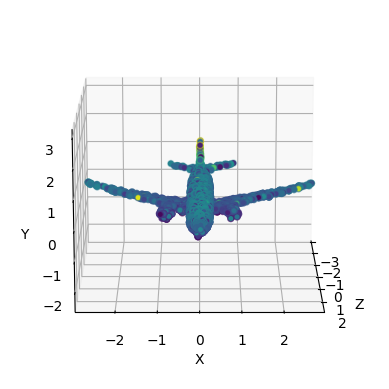

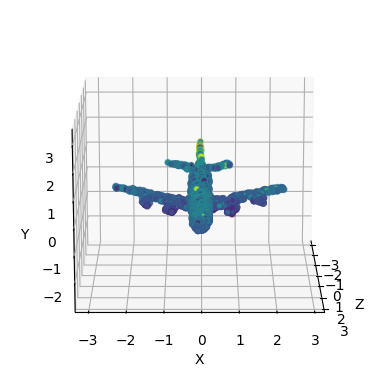

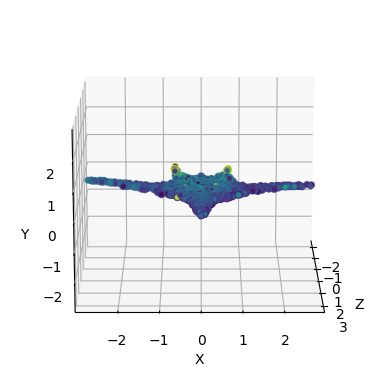

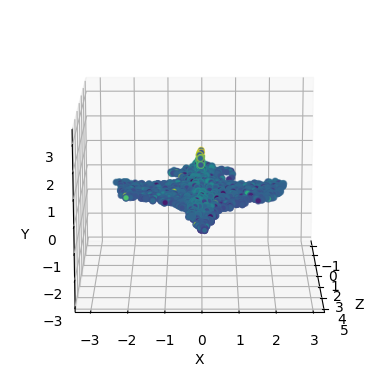

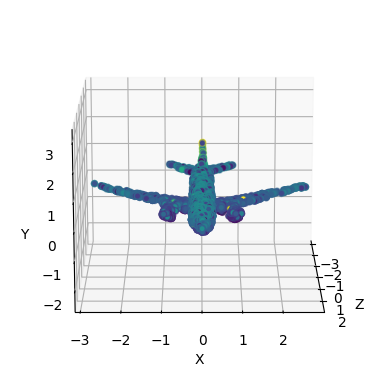

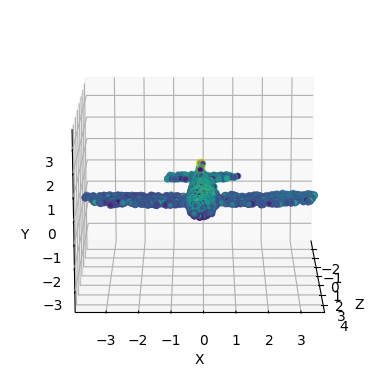

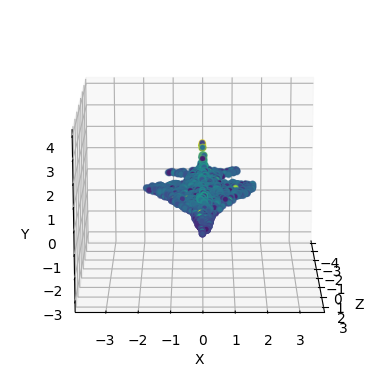

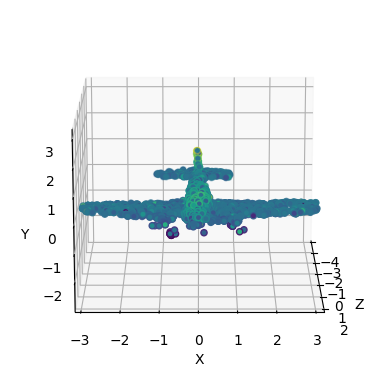

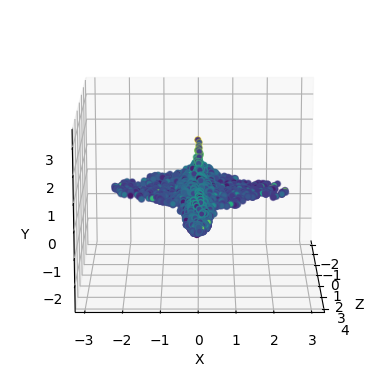

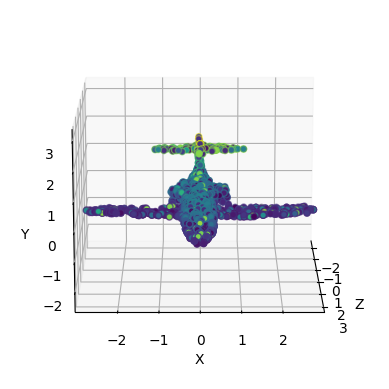

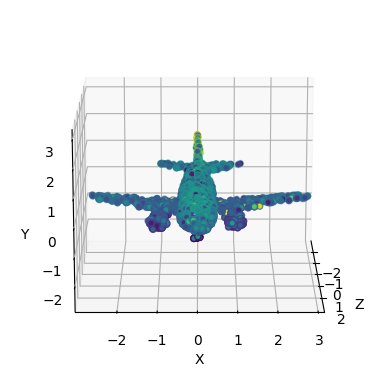

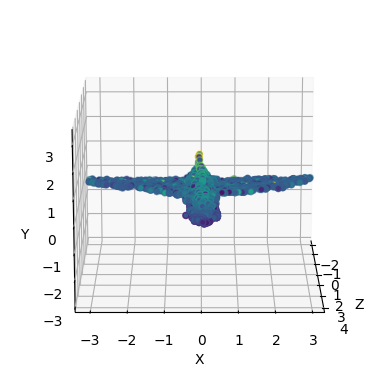

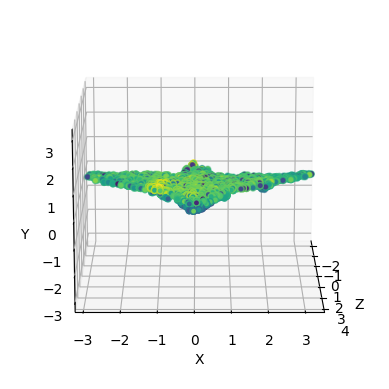

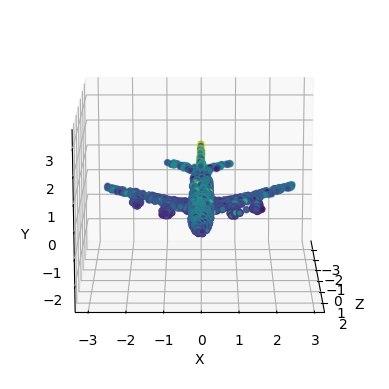

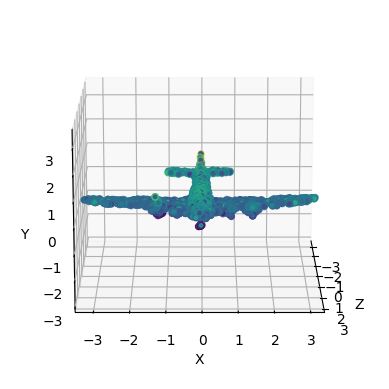

In [49]:
from visuals.visuals_util import visualize_pointcloud

for sample in train_dataloader:
    print(sample["train_points"].cpu().numpy().squeeze().shape)
    visualize_pointcloud(sample["train_points"].cpu().numpy().squeeze())

In [12]:
from train_refinement import symmetry_loss

for sample in train_dataloader:
    xy = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='xy')
    xz = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='xz')
    yz = symmetry_loss(sample["train_points"].squeeze(), symmetry_plane='yz')
    
    print(f"XY: {xy.item():.4f}; XZ: {xz.item():.4f}; YZ: {yz.item():.4f}")

XY: 4.3620; XZ: 1.3358; YZ: 9.3473
XY: 5.5071; XZ: 0.3254; YZ: 4.2447
XY: 6.1912; XZ: 0.4545; YZ: 3.4436
XY: 8.0291; XZ: 0.4130; YZ: 3.3828
XY: 3.4484; XZ: 0.0712; YZ: 5.1705
XY: 6.5837; XZ: 0.1480; YZ: 2.5851
XY: 8.4802; XZ: 0.1437; YZ: 2.3042
XY: 1.7147; XZ: 0.0809; YZ: 3.2003
XY: 12.2023; XZ: 0.1020; YZ: 3.5406
XY: 8.4286; XZ: 0.2425; YZ: 2.5106
XY: 7.7748; XZ: 0.3438; YZ: 9.2877
XY: 14.5167; XZ: 0.2502; YZ: 1.7279
XY: 9.5460; XZ: 0.0833; YZ: 6.0450
XY: 9.7086; XZ: 0.2403; YZ: 2.6940
XY: 6.5553; XZ: 0.8985; YZ: 2.9826
XY: 7.0800; XZ: 0.4994; YZ: 3.2423
XY: 5.4182; XZ: 0.1326; YZ: 5.6004
XY: 4.7611; XZ: 0.1324; YZ: 6.3927
XY: 9.8677; XZ: 0.2198; YZ: 3.1520
XY: 5.0289; XZ: 0.1768; YZ: 5.8007


In [13]:
from scipy.spatial import cKDTree
from train_refinement import smoothness_loss
import torch

def find_neighbors(point_cloud, k=16):
    # Convert tensor to numpy array for cKDTree
    point_cloud_np = point_cloud.detach().cpu().numpy()
    tree = cKDTree(point_cloud_np)
    # Query the tree for the k nearest neighbors
    _, indices = tree.query(point_cloud_np, k=k+1)  # k+1 because the point itself is included
    # Convert to tensor (skip the first column which is the point itself)
    neighbors_indices = torch.from_numpy(indices[:, 1:]).to(point_cloud.device)
    return neighbors_indices

for sample in train_dataloader:
    point_cloud = sample["train_points"].squeeze()  # Assuming point_cloud shape is (2048, 3)
    neighbors = find_neighbors(point_cloud)
    smoothness = smoothness_loss(point_cloud, neighbors)
    print(f"Smoothness Loss: {smoothness.item():.4f}")


Smoothness Loss: 0.7801
Smoothness Loss: 0.3984
Smoothness Loss: 0.3114
Smoothness Loss: 0.5052
Smoothness Loss: 0.3318
Smoothness Loss: 0.2611
Smoothness Loss: 0.2956
Smoothness Loss: 0.1903
Smoothness Loss: 0.4466
Smoothness Loss: 0.2804
Smoothness Loss: 0.3863
Smoothness Loss: 0.5091
Smoothness Loss: 0.3850
Smoothness Loss: 0.5483
Smoothness Loss: 0.3976
Smoothness Loss: 0.4291
Smoothness Loss: 0.3757
Smoothness Loss: 0.4170
Smoothness Loss: 0.3081
Smoothness Loss: 0.3233
